# Deep Learning with a Small Data Set

## Objective

The original casting data set has 

Based on [this article](https://machinelearningmastery.com/model-averaging-ensemble-for-deep-learning-neural-networks/).

In [1]:
import pathlib
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from sklearn.metrics import confusion_matrix, classification_report

import casting_defects_sample_data
import casting_defects_plots
import casting_defects_models

Using TensorFlow backend.


In [2]:
BATCH_SIZE = 64
NO_EPOCHS = 10
TRAIN_NEURAL_NETWORK = False
NO_MODELS = 10

plt.style.use('ggplot')

In [3]:
# Setup output directory if it does not exist.
output_dir = pathlib.Path().cwd() / 'output'
try:
    output_dir.mkdir()
except FileExistsError:
    pass

In [4]:
# Take a sample of the original data. 
orig_dir = pathlib.Path.cwd().parent  / 'input'
sample_dir = pathlib.Path().cwd() / 'sample_data/'

casting_defects_sample_data.sample_data(
    orig_dir, pathlib.Path().cwd() / 'sample_data/', no_train=50, no_test=125)

In [5]:
# Instantiate image generators on sampled data.
input_dir = sample_dir
data_sets = ('train', 'test')
train_dir, test_dir = [next(input_dir.rglob(ds)) for ds in data_sets]

trainval_datagen = ImageDataGenerator(
    rescale=1. / 255,
    validation_split=0.2
)
test_datagen = ImageDataGenerator(
    rescale=1. / 255
)

# Create neural network architecture.
model = Sequential([
    Conv2D(32, kernel_size=3, input_shape=(300, 300, 1), activation='relu'),
    MaxPool2D(4),
    Conv2D(64, kernel_size=3, input_shape=(300, 300, 1), activation='relu'),
    MaxPool2D(4),
    Conv2D(32, kernel_size=3, input_shape=(300, 300, 1), activation='relu'),
    Flatten(),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 298, 298, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        18464     
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

Found 80 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
Found 250 images belonging to 2 classes.
Found 50 images belonging to 1 classes.
Found 50 images belonging to 1 classes.


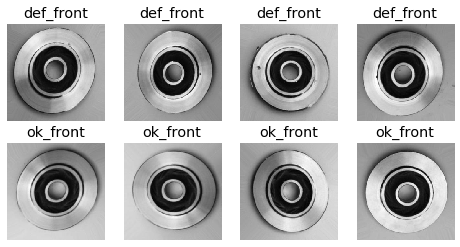

In [6]:
# Instantiate a custom CastingDefectsModels class.
# Provides methods for training , evaluating and predicting on and 
# ensemble of models. 
cdf = casting_defects_models.CastingDefectModels(
    train_dir=train_dir,
    test_dir=test_dir,
    output_dir=output_dir / 'simple_cnn',
    trainval_datagen=trainval_datagen,
    test_datagen=test_datagen,
    model=model,
    no_epochs=NO_EPOCHS
)

# Generate some examples of pre-processed images.
example_plot = cdf.generate_examples(nrows=1, ncols=4)

In [7]:
# Train models.
if TRAIN_NEURAL_NETWORK:
    cdf.train_models(no_models=NO_MODELS)
    

In [8]:
# Compute history.
history = cdf.gather_ensemble_history()   

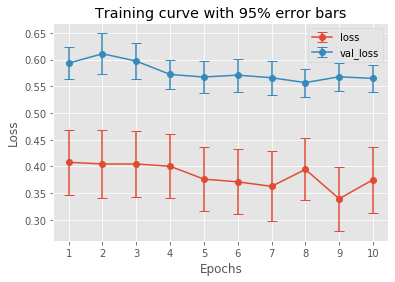

In [9]:
plot_ensemble_hist = cdf.plot_ensemble_history() 

In [10]:
pred_prob, raw_predictions = cdf.ensemble_predictions()

Predicting with model #0001: model_5cadd3bc-46a8-4f9a-bbbd-cf447bf13e14.h5
Predicting with model #0002: model_4d3df5ed-82d4-4632-897d-c765213ed90c.h5
Predicting with model #0003: model_48554b19-feef-4d6b-8a0f-9d2e0eeec07a.h5
Predicting with model #0004: model_811eeeff-7120-4282-a938-40580b56a83e.h5
Predicting with model #0005: model_1e0a9ca9-1d25-4c9c-b1a9-9c60af357979.h5
Predicting with model #0006: model_28e6efe0-8921-47a2-9274-7a5e5ae2b36a.h5
Predicting with model #0007: model_23076204-05eb-449b-b95e-9473ff2d8193.h5
Predicting with model #0008: model_dc43f0f7-cd64-4427-b2ec-dea1eade804f.h5
Predicting with model #0009: model_f6ef2701-f704-4b8f-9f53-0a1430e396a7.h5
Predicting with model #0010: model_03350889-7abc-49c3-9b40-7aca51a16189.h5
Predicting with model #0011: model_6428eaa4-86f7-407d-9b19-2317cb3b2837.h5
Predicting with model #0012: model_9c99fe96-d9fa-40aa-98d0-716aa4ef9c5d.h5
Predicting with model #0013: model_d5fe0cbf-152c-4ea4-b266-88cc55d08f80.h5
Predicting with model #00

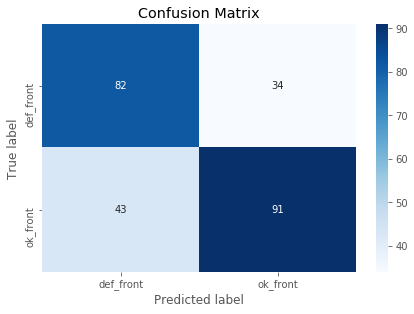

In [11]:
# Predicted class
pred_class = [elem > 0.5 for elem in pred_prob['mean']]

# True class.
true_class = cdf.test_generator.classes

# Get label/target encoding.
class_indices = [[k, v] for k, v in cdf.test_generator.class_indices.items()]
target_names, labels = list(zip(*class_indices))
cm = confusion_matrix(pred_class, true_class)

casting_defects_plots.plot_confusion_matrix(cm, labels=target_names)
 

In [12]:
print(classification_report(pred_class, true_class,
                            labels=labels, target_names=target_names))

              precision    recall  f1-score   support

   def_front       0.66      0.71      0.68       116
    ok_front       0.73      0.68      0.70       134

    accuracy                           0.69       250
   macro avg       0.69      0.69      0.69       250
weighted avg       0.69      0.69      0.69       250



No handles with labels found to put in legend.


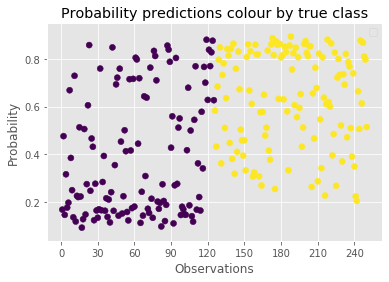

In [13]:
from matplotlib.ticker import MaxNLocator
fig, ax = plt.subplots()

mean_prob = pred_prob['mean']
std_err_prob = pred_prob['std_err']

ax.scatter(x=range(1, len(mean_prob) + 1),
           y=mean_prob,
           c=true_class)
ax.set_title('Probability predictions colour by true class')
ax.set_xlabel('Observations')
ax.set_ylabel('Probability')
ax.legend()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
